In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

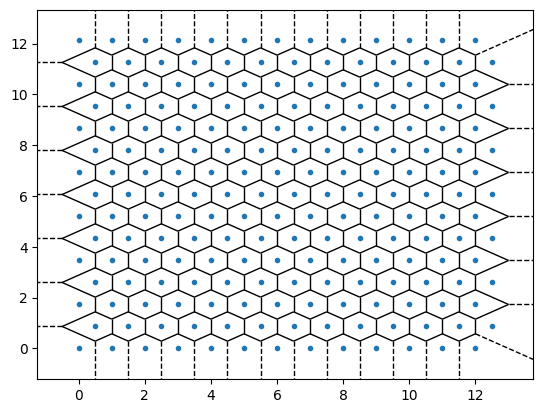

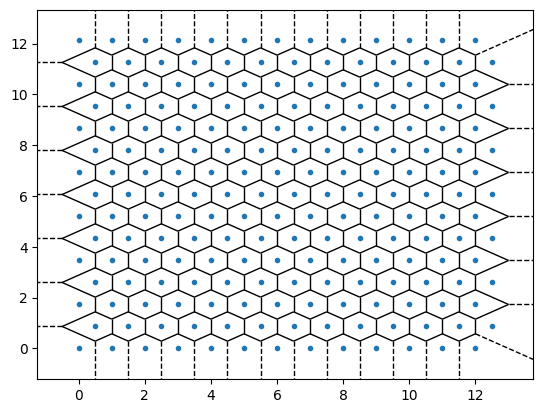

In [ ]:
def make_triangular_lattice_squareish(N_target=None, a=1.0, prefer_more=True):
    """
    Build a perfect triangular (hexagonal) lattice inside [0,Lx)×[0,Ly) with:
        x = i*a + (j%2)*(a/2)
        y = j*(sqrt(3)/2)*a
    We choose integers (nx, ny) so that Lx ~ Ly (square-ish) and N = nx*ny is
    close to N_target (if given). Returns (points, Lx, Ly, nx, ny, N).

    Args:
        N_target : int or None
            Desired number of points. If None, you can set nx,ny yourself
            by editing the quick default below.
        a        : float
            Lattice spacing (edge-to-edge spacing between neighbors).
        prefer_more : bool
            If True, when we can’t hit N_target exactly we pick N >= N_target;
            otherwise we pick N <= N_target.

    Notes:
        - Voronoi of this point set is a perfect **regular hexagon** tiling
          (up to border effects). With your periodic-image machinery, it becomes
          perfectly periodic.
        - Lx = nx*a, Ly = ny*(sqrt(3)/2)*a, and N = nx*ny.
    """
    root3 = np.sqrt(3.0)

    # If user didn't give N_target, set a square-ish default here:
    if N_target is None:
        # Example default: ~1200 points in a square-ish box
        N_target = 1200

    # Heuristic: for Lx ≈ Ly, you want nx ≈ ny * (sqrt(3)/2)
    # So ny ~ sqrt( (2/√3) * N ), nx ~ (√3/2) * ny
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    # Search a small window around the estimate to find a nice (nx, ny)
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        # If we must be on one side of N_target, adjust nx a bit
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            N2 = nx2 * ny
            nx, N = nx2, N2
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            N2 = nx2 * ny
            nx, N = nx2, N2

        # Skip if adjustment zeroed N
        if N <= 0:
            continue

        # Aspect score: want Lx ≈ Ly
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        # Cost: prioritize aspect, then closeness to N_target
        cost = (aspect - 1.0)**2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # Build the lattice points
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1

    # Ensure exactly N points
    assert idx == N

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices_perturbed):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for key in explicit_voronoi.keys():
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # print('common edge:', common_edges)
            # mirror m_final across the common edge
            common_vertex1_coord = vertices_perturbed[common_edges[0][0]]
            common_vertex2_coord = vertices_perturbed[common_edges[0][1]]
            
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness


def poisson_disk_sampling(N_target, aspect_ratio=1.0, k=30):
    """
    Generate ~N_target Poisson-disk points in a rectangular domain
    with approximately equal counts in x and y directions.

    Args:
        N_target : int
            Desired number of points.
        aspect_ratio : float
            Width / Height ratio (1.0 → square domain).
        k : int
            Number of candidate attempts per active point.

    Returns:
        points : (N,2) array of coordinates in [0,Lx]×[0,Ly]
        Lx, Ly : domain size
    """
    # --- Estimate domain size to keep N_target ~ ρ * Area  ---
    # We'll assume density ρ ~ 1 / (π r^2)
    # For a square-like domain, we want Lx ≈ Ly, and N_target ≈ Area / (π r^2)
    # We pick r so that Area ≈ N_target * π r^2 → r ≈ 1/√(π N_target)
    r = 1 / np.sqrt(np.pi * N_target)
    Lx = np.sqrt(aspect_ratio)
    Ly = 1.0 / np.sqrt(aspect_ratio)

    # Grid parameters
    cell_size = r / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(Lx / cell_size)), int(np.ceil(Ly / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)

    # Lists of points and active samples
    points = []
    active = []

    # Start with one random point
    p0 = np.array([np.random.uniform(0, Lx), np.random.uniform(0, Ly)])
    points.append(p0)
    active.append(0)
    grid[int(p0[1] // cell_size), int(p0[0] // cell_size)] = 0

    while active and len(points) < N_target * 1.3:
        idx = np.random.choice(active)
        base = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2*np.pi)
            radius = np.random.uniform(r, 2*r)
            p = base + radius * np.array([np.cos(theta), np.sin(theta)])
            if not (0 <= p[0] < Lx and 0 <= p[1] < Ly):
                continue
            gx, gy = int(p[0] // cell_size), int(p[1] // cell_size)
            ok = True
            for ny in range(max(gy-2,0), min(gy+3,grid_h)):
                for nx in range(max(gx-2,0), min(gx+3,grid_w)):
                    n = grid[ny, nx]
                    if n != -1 and np.linalg.norm(points[n] - p) < r:
                        ok = False
                        break
                if not ok:
                    break
            if ok:
                points.append(p)
                active.append(len(points)-1)
                grid[gy, gx] = len(points)-1
                found = True
                break
        if not found:
            active.remove(idx)

    points = np.array(points)
    # Randomly trim to exact count
    if len(points) > N_target:
        points = points[np.random.choice(len(points), N_target, replace=False)]

    return points, Lx, Ly




points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True)




In [ ]:
# points, Lx, Ly, nx, ny, N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True)
number_of_tests = 1000
voronoiness_storage = []
for i in range(number_of_tests):

    # points, Lx, Ly = poisson_disk_sampling(300, aspect_ratio=1.0)
    points = np.random.rand(1000,2)
    Lx = 1.0
    Ly = 1.0

    # Generate Voronoi diagram
    vor = Voronoi(points)
    # plot initial Voronoi diagram
    fig, ax = plt.subplots(figsize=(6, 6))
    voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')

    # perturbation
    perturbation_strength = 1/np.sqrt(len(points))*1e-1  # Adjust this value to control the amount of perturbation
    print("Perturbation strength:", perturbation_strength)
    vertices_coords = vor.vertices.copy()

    # find the central vertex of the tessellation
    center_of_box = np.array([Lx/2, Ly/2], float)
    center_idx = np.argmin(np.linalg.norm(vertices_coords - center_of_box[None, :], axis=1))
    print("Center vertex index:", center_idx)

    # Perturb only the central vertex, the amount of perturbation is 'perturbation_strength', direction is random
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)  # normalize to unit vector
    vertices_coords[center_idx] += perturbation_strength * random_direction

    # iterative center search
    from Main_Function import fun_vor_main
    (explicit_voronoi_perturbed, 
    vertices_perturbed, 
    cell_centers_perturbed, 
    distance_original_list_perturbed, 
    distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)

    # calculate non-voronoiness per seed
    nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,vertices_perturbed)
    voronoiness_storage.append(nonvoronoiness)


In [5]:
# PLOTTING
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d

# ------------------------------------------------------------
# 1️⃣  Compute per-cell displacement magnitude
# ------------------------------------------------------------
N_real = len(points)
disp = np.linalg.norm(cell_centers_perturbed - points, axis=1)

# ------------------------------------------------------------
# 2️⃣  Rebuild Voronoi using the same ghost padding as inside your function
# ------------------------------------------------------------
# buffer = 0.1
# xmin, ymin = np.min(points, axis=0) - buffer
# xmax, ymax = np.max(points, axis=0) + buffer

# ghost_x = np.linspace(xmin, xmax, 10)
# ghost_y = np.linspace(ymin, ymax, 10)
# ghosts = np.array([[x, y] for x in ghost_x for y in ghost_y
#                    if (x < np.min(points[:, 0]) or x > np.max(points[:, 0]) or
#                        y < np.min(points[:, 1]) or y > np.max(points[:, 1]))])

# all_points = np.vstack([points, ghosts])
# vor = Voronoi(all_points)

# ------------------------------------------------------------
# 3️⃣  Build colored finite polygons (central cells only)
# ------------------------------------------------------------
patches, colors = [], []
for i in range(N_real):
    region_index = vor.point_region[i]
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        continue  # skip infinite regions
    polygon = np.array([vor.vertices[j] for j in region])
    patches.append(Polygon(polygon, closed=True))
    colors.append(disp[i])

# ------------------------------------------------------------
# 4️⃣  Plot setup (a_periodic style)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

pc = PatchCollection(
    patches,
    cmap='viridis',
    edgecolor='none',
    alpha=0.8
)
pc.set_array(np.array(colors))
ax.add_collection(pc)

# Overlay Voronoi edges
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                line_colors='black', line_width=0.4, line_alpha=0.6)

# Add seed points
# ax.scatter(points[:, 0], points[:, 1], c='red', s=8, label='Original seeds', zorder=3)

# ------------------------------------------------------------
# 5️⃣  Axes & colorbar styling
# ------------------------------------------------------------
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.set_xlabel('x-coordinate', fontsize=10)
ax.set_ylabel('y-coordinate', fontsize=10)
ax.set_title('Displacement Magnitude $|Δ|$ (Recovered vs Original)', fontsize=11)
ax.legend(loc='upper right', fontsize=8)
#plot cell centers
# ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'r.', label='Recovered cell centers', markersize=5, zorder=4)
# ax.plot(points[:, 0], points[:, 1], 'r.', label='Original seeds', markersize=5, zorder=4)

cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


NameError: name 'cell_centers_perturbed' is not defined

In [11]:
import numpy as np
from scipy.spatial import Voronoi
from joblib import Parallel, delayed
from tqdm import tqdm
from Main_Function import fun_vor_main
# from Main_Function import fun_vor_main
# from your_module import nonvoronoiness_per_seed
def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices_perturbed):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for key in explicit_voronoi.keys():
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # print('common edge:', common_edges)
            # mirror m_final across the common edge
            common_vertex1_coord = vertices_perturbed[common_edges[0][0]]
            common_vertex2_coord = vertices_perturbed[common_edges[0][1]]
            
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def single_test(i, N_points=1000, Lx=1.0, Ly=1.0):
    # --- Random points (can be replaced by Poisson disk)
    points = np.random.rand(N_points, 2)

    # --- Generate Voronoi diagram
    vor = Voronoi(points)

    # --- Perturbation setup
    perturbation_strength = 1 / np.sqrt(N_points) * 1e-1
    vertices_coords = vor.vertices.copy()

    # --- Find central vertex (as perturbation origin)
    center_of_box = np.array([Lx / 2, Ly / 2])
    center_idx = np.argmin(np.linalg.norm(vertices_coords - center_of_box[None, :], axis=1))

    # --- Random perturbation direction
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[center_idx] += perturbation_strength * random_direction
    perturbed_vertex = vertices_coords[center_idx].copy()


    # --- Inverse Voronoi reconstruction
    (explicit_voronoi_perturbed,
     vertices_perturbed,
     cell_centers_perturbed,
     distance_original_list_perturbed,
     distance_from_found_to_previous_perturbed) = fun_vor_main(vor, points, vertices_coords)

    # --- Compute non-voronoiness per seed
    nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed,
                                             explicit_voronoi_perturbed,
                                             vertices_perturbed)

    # --- Return data for later spatial decay analysis
    result = {
        "cell_centers": np.array(points),
        "nonvoronoiness": np.array(nonvoronoiness),
        "perturbed_vertex": perturbed_vertex,
    }
    return result

number_of_tests = 2
N_points = 1000

print(f"Running {number_of_tests} trials with {N_points} points each...")

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(single_test)(i, N_points)
    for i in tqdm(range(number_of_tests))
)

# Save for later postprocessing
np.save("voronoi_decay_data.npy", results, allow_pickle=True)

print("✅ All data saved to voronoi_decay_data.npy")

Running 2 trials with 1000 points each...


100%|██████████| 2/2 [00:00<?, ?it/s]


✅ All data saved to voronoi_decay_data.npy


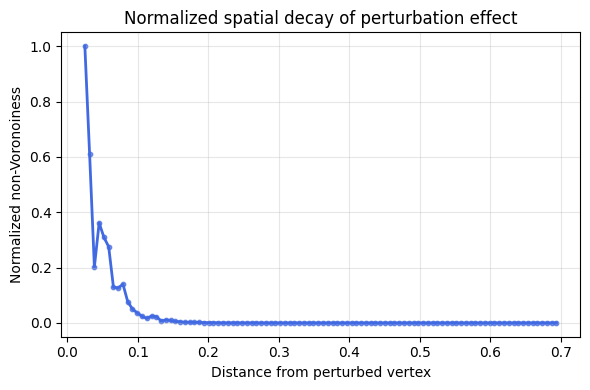

In [9]:
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
data = np.load("voronoi_decay_data.npy", allow_pickle=True)

all_distances = []
all_values = []

# ------------------------------------------------------------
# Gather all cell distances and non-voronoiness values
# ------------------------------------------------------------
for trial in data:
    centers = trial["cell_centers"]
    values = trial["nonvoronoiness"]
    perturbed_vertex = trial["perturbed_vertex"]

    distances = np.linalg.norm(centers - perturbed_vertex[None, :], axis=1)

    all_distances.extend(distances)
    all_values.extend(values)

all_distances = np.array(all_distances)
all_values = np.array(all_values)

# ------------------------------------------------------------
# Bin distances to compute radial averages
# ------------------------------------------------------------
n_bins = 100  # number of radial bins
r_min, r_max = all_distances.min(), all_distances.max()
bin_means, bin_edges, _ = binned_statistic(
    all_distances, all_values, statistic='mean', bins=n_bins, range=(r_min, r_max)
)

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# ------------------------------------------------------------
# Normalize the decay curve (max = 1)
# ------------------------------------------------------------
bin_means_norm = bin_means / np.nanmax(bin_means)

# ------------------------------------------------------------
# Plot normalized decay curve
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, bin_means_norm, '-', lw=2, color='royalblue')
plt.scatter(bin_centers, bin_means_norm, s=10, color='royalblue', alpha=0.7)

plt.xlabel("Distance from perturbed vertex")
plt.ylabel("Normalized non-Voronoiness")
plt.title("Normalized spatial decay of perturbation effect")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Benchmarking parallel scaling...

▶ Running with 1 cores...


            Converged after 112 iterations


            Converged after 114 iterations


            Converged after 121 iterations


            Converged after 120 iterations


            Converged after 128 iterations


            Converged after 130 iterations


            Converged after 141 iterations


            Converged after 113 iterations


            Converged after 126 iterations


            Converged after 117 iterations


            Converged after 116 iterations


100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


            Converged after 115 iterations
   → Total time: 11.89 s,  Avg per tessellation: 0.99 s

▶ Running with 2 cores...


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


   → Total time: 7.13 s,  Avg per tessellation: 0.59 s

▶ Running with 3 cores...


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


   → Total time: 5.29 s,  Avg per tessellation: 0.44 s

▶ Running with 4 cores...


100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


   → Total time: 4.58 s,  Avg per tessellation: 0.38 s

▶ Running with 5 cores...


100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


   → Total time: 4.40 s,  Avg per tessellation: 0.37 s

▶ Running with 6 cores...


100%|██████████| 12/12 [00:01<00:00, 10.11it/s]


   → Total time: 3.11 s,  Avg per tessellation: 0.26 s


=== Parallel Scaling Summary ===
 1 cores →   0.99 s/test   | Speedup =  1.00×   | Efficiency = 100.0%
 2 cores →   0.59 s/test   | Speedup =  1.67×   | Efficiency =  83.4%
 3 cores →   0.44 s/test   | Speedup =  2.25×   | Efficiency =  74.9%
 4 cores →   0.38 s/test   | Speedup =  2.60×   | Efficiency =  64.9%
 5 cores →   0.37 s/test   | Speedup =  2.70×   | Efficiency =  54.1%
 6 cores →   0.26 s/test   | Speedup =  3.83×   | Efficiency =  63.8%


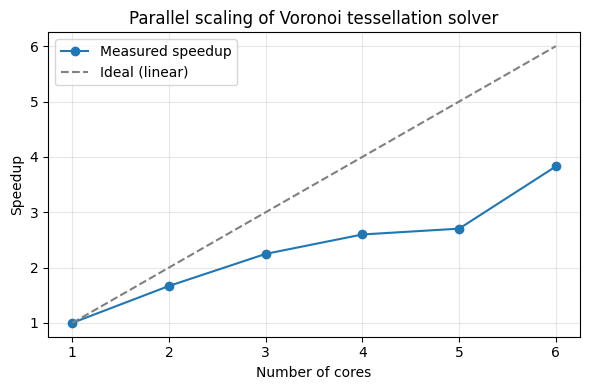

In [13]:
import time
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices_perturbed):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for key in explicit_voronoi.keys():
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # print('common edge:', common_edges)
            # mirror m_final across the common edge
            common_vertex1_coord = vertices_perturbed[common_edges[0][0]]
            common_vertex2_coord = vertices_perturbed[common_edges[0][1]]
            
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def single_test(i, N_points=100, Lx=1.0, Ly=1.0):
    # --- Random points (can be replaced by Poisson disk)
    points = np.random.rand(N_points, 2)

    # --- Generate Voronoi diagram
    vor = Voronoi(points)

    # --- Perturbation setup
    perturbation_strength = 1 / np.sqrt(N_points) * 1e-1
    vertices_coords = vor.vertices.copy()

    # --- Find central vertex (as perturbation origin)
    center_of_box = np.array([Lx / 2, Ly / 2])
    center_idx = np.argmin(np.linalg.norm(vertices_coords - center_of_box[None, :], axis=1))

    # --- Random perturbation direction
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[center_idx] += perturbation_strength * random_direction
    perturbed_vertex = vertices_coords[center_idx].copy()


    # --- Inverse Voronoi reconstruction
    (explicit_voronoi_perturbed,
     vertices_perturbed,
     cell_centers_perturbed,
     distance_original_list_perturbed,
     distance_from_found_to_previous_perturbed) = fun_vor_main(vor, points, vertices_coords)

    # --- Compute non-voronoiness per seed
    nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed,
                                             explicit_voronoi_perturbed,
                                             vertices_perturbed)

    # --- Return data for later spatial decay analysis
    result = {
        "cell_centers": np.array(points),
        "nonvoronoiness": np.array(nonvoronoiness),
        "perturbed_vertex": perturbed_vertex,
    }
    return result


# ----------------------------------------------------------
# Benchmark setup
# ----------------------------------------------------------
N_total = 12    # total number of tessellations per benchmark run
core_list = [1, 2, 3, 4, 5, 6]  # cores to test

times = []

print("Benchmarking parallel scaling...\n")

for n_jobs in core_list:
    print(f"▶ Running with {n_jobs} cores...")
    start = time.perf_counter()

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(single_test)(i) for i in tqdm(range(N_total))
    )

    elapsed = time.perf_counter() - start
    avg_time_per_case = elapsed / N_total
    times.append(avg_time_per_case)

    print(f"   → Total time: {elapsed:.2f} s,  Avg per tessellation: {avg_time_per_case:.2f} s\n")


# ----------------------------------------------------------
# Compute speedups and efficiency
# ----------------------------------------------------------
times = np.array(times)
speedup = times[0] / times
efficiency = speedup / np.array(core_list)

print("\n=== Parallel Scaling Summary ===")
for n, t, s, e in zip(core_list, times, speedup, efficiency):
    print(f"{n:>2} cores → {t:6.2f} s/test   | Speedup = {s:5.2f}×   | Efficiency = {e*100:5.1f}%")

# ----------------------------------------------------------
# Plot results
# ----------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(core_list, speedup, 'o-', label="Measured speedup")
plt.plot(core_list, core_list, '--', color='gray', label="Ideal (linear)")
plt.xlabel("Number of cores")
plt.ylabel("Speedup")
plt.title("Parallel scaling of Voronoi tessellation solver")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


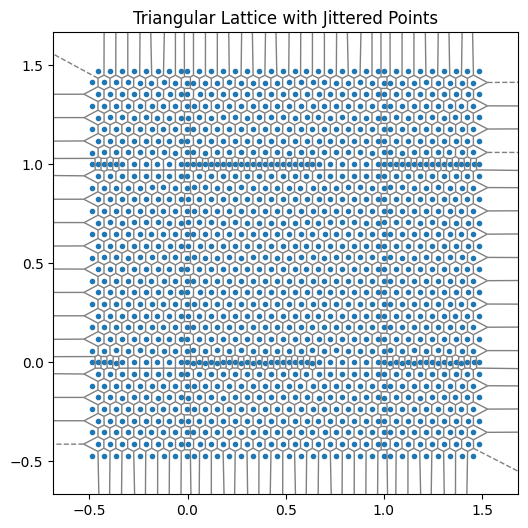

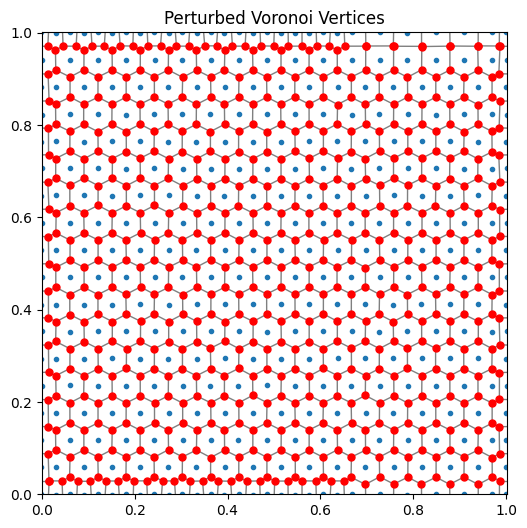

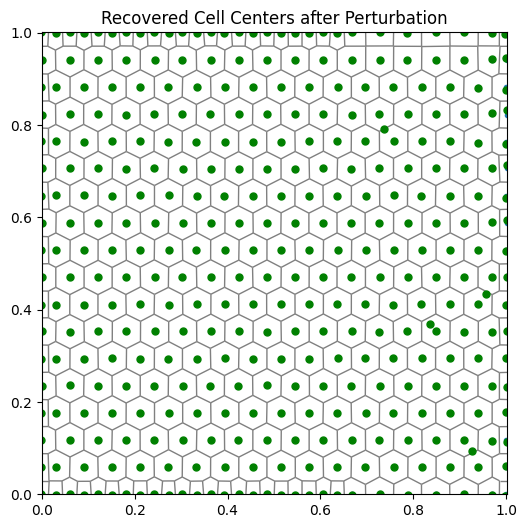

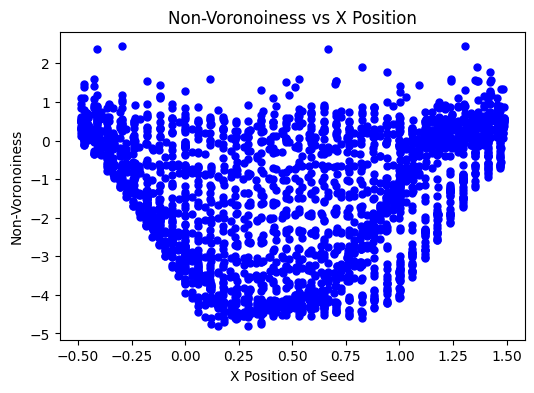

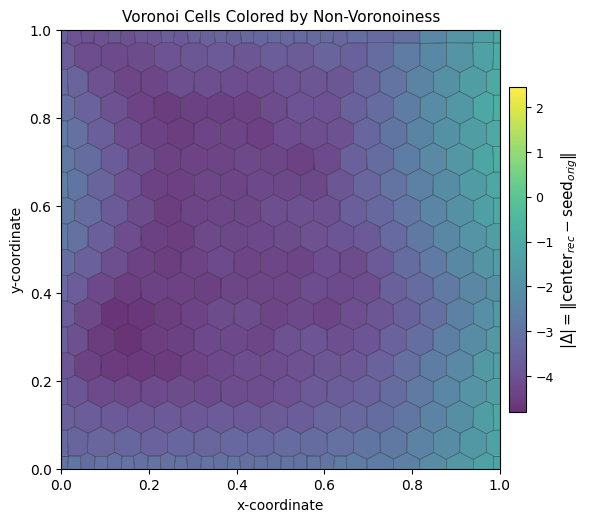

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices_perturbed):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for key in explicit_voronoi.keys():
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # print('common edge:', common_edges)
            # mirror m_final across the common edge
            common_vertex1_coord = vertices_perturbed[common_edges[0][0]]
            common_vertex2_coord = vertices_perturbed[common_edges[0][1]]
            
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()




# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
central_seed_coords, Lx, Ly  = hexagonal_points(300,randomization_strength=1e-2)
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
# ax.set_xlim(0,Lx)
# ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION INCREASING FROM LEFT TO RIGHT
max_perturbation_strength = 1/np.sqrt(300) * 1e-4  # maximum perturbation strength at the right edge
vertices_coords = vor.vertices.copy()
for i in range(len(vertices_coords)):
    x, y = vertices_coords[i]
    t = abs(x / Lx) 
    local_perturbation_strength = t * max_perturbation_strength
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[i] += local_perturbation_strength * random_direction

# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,vertices_perturbed)
nonvoronoiness = np.log10(nonvoronoiness)
# non_voronoiness_ofcentral_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(points, nonvoronoiness, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoiness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)


# PLOT VORONOI CELLS COLORED BY NON-VORONOINESS
plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title="Voronoi Cells Colored by Non-Voronoiness", cmap='viridis')









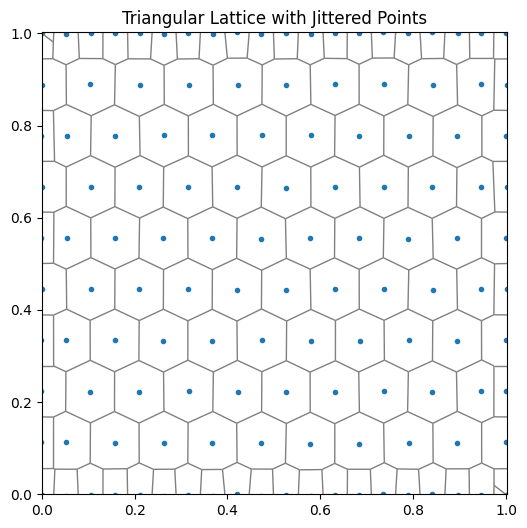

            Converged after 179 iterations


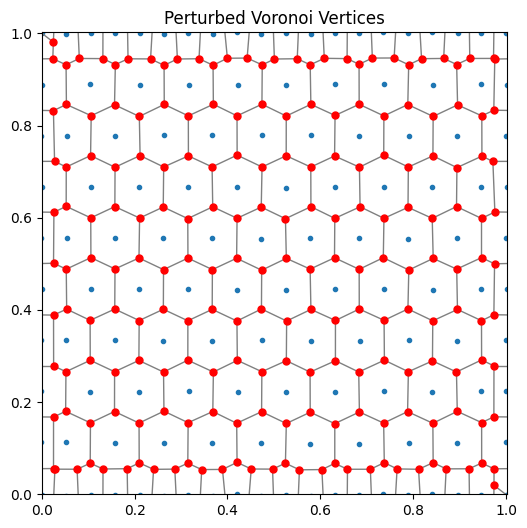

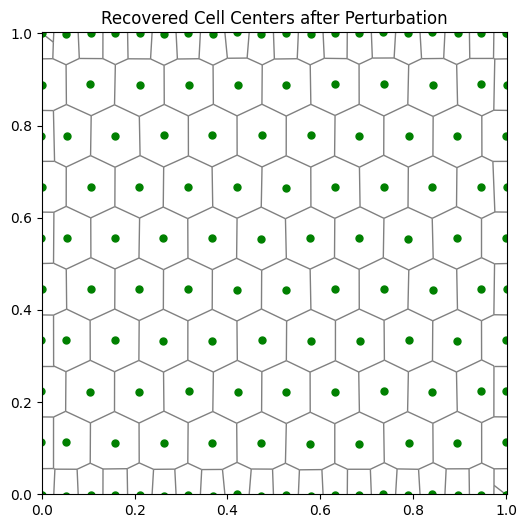

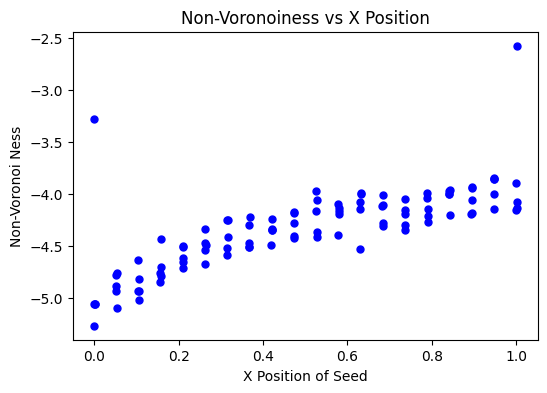

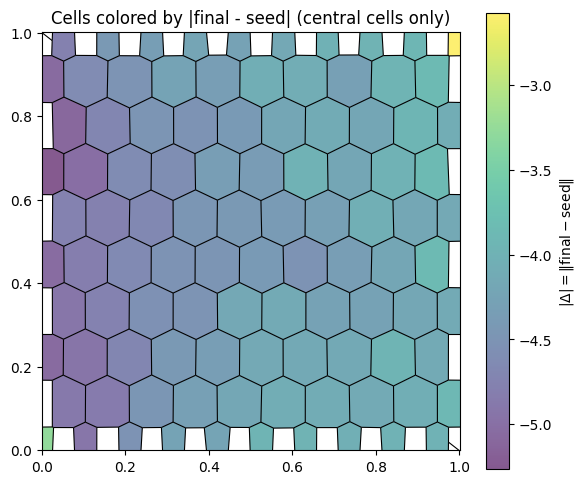

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    # ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()




# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
central_seed_coords, Lx, Ly  = hexagonal_points(100,randomization_strength=0.01)
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
ax.set_xlim(0,Lx)
ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION INCREASING FROM LEFT TO RIGHT
max_perturbation_strength = 1/np.sqrt(N_central)*1e-4  # maximum perturbation strength at the right edge
original_vertices = vor.vertices.copy()
vertices_coords = vor.vertices.copy()
for i in range(len(vertices_coords)):
    if vertices_coords[i,0]<0 or vertices_coords[i,0]>Lx or vertices_coords[i,1]<0 or vertices_coords[i,1]>Ly:
        continue  # only perturb vertices inside the box
    x, y = vertices_coords[i]
    t = x / Lx
    local_perturbation_strength = t * max_perturbation_strength
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[i] += local_perturbation_strength * random_direction

# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)
nonvoronoiness = np.log10(nonvoronoiness)
nonvoronoiness_of_central_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoi Ness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)


# # PLOT VORONOI CELLS COLORED BY NON-VORONOINESS
# plot_colored_voronoi(vor, nonvoronoiness,N_central title="Voronoi Cells Colored by Non-Voronoiness", cmap='viridis')

# # PLOT DISTANCE FROM RECOVERED CENTERS TO ORIGINAL SEEDS
# dist = np.linalg.norm(cell_centers_perturbed - points, axis=1)
# plot_colored_voronoi(vor, dist,N_central, title="Voronoi Cells Colored by Distance from Recovered Centers to Original Seeds", cmap='plasma')

# --- per-site non-voronoiness (for central points only) ---


# --- build filled polygons for central seeds only (0..N_central_seeds-1) ---
patches, colors = [], []
for i in range(N_central):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    colors.append(nonvoronoiness[i])            # color by displacement of seed i

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# filled cells colored by |Δ|
pc = PatchCollection(patches, cmap='viridis', alpha=0.65, edgecolor='none')
pc.set_array(np.asarray(colors))
ax.add_collection(pc)

# overlay Voronoi edges for context
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=0.8, point_size=0)

# axes & title
ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_aspect('equal', adjustable='box')
ax.set_title('Cells colored by |final - seed| (central cells only)')

# (optional) annotate central seeds and scatter initial/final markers
# for i, (px, py) in enumerate(central_seed_coords):
#     ax.text(px, py, str(i), fontsize=7, ha='center', va='center',
#             color='white', bbox=dict(boxstyle='round,pad=0.15', fc='black', ec='none', alpha=0.5))
# ax.plot(initial_coords[:, 0], initial_coords[:, 1], 'go', ms=3, label='initial')
# ax.plot(final_coords[:, 0],    final_coords[:, 1],    'rx', ms=3, label='final')
# ax.legend(loc='upper right', fontsize=8)

# colorbar
cbar = plt.colorbar(pc, ax=ax, shrink=0.8)
cbar.set_label(r'$|\Delta| = \|\mathrm{final}-\mathrm{seed}\|$')

plt.tight_layout()
plt.show()







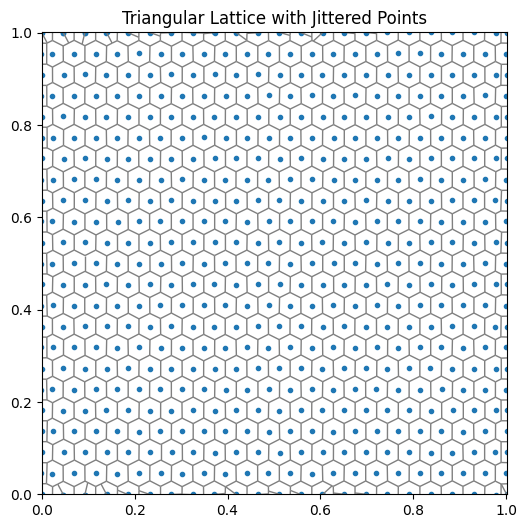

            Converged after 165 iterations


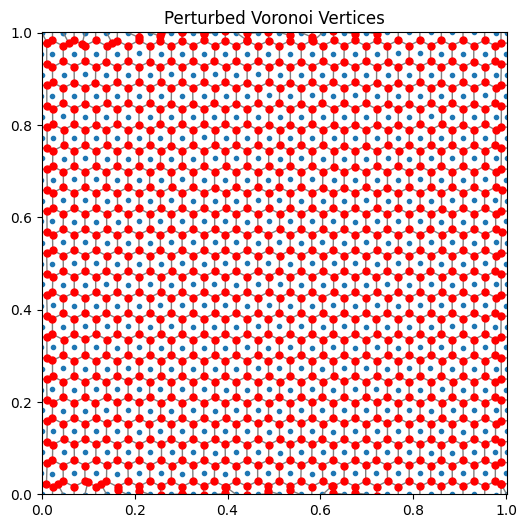

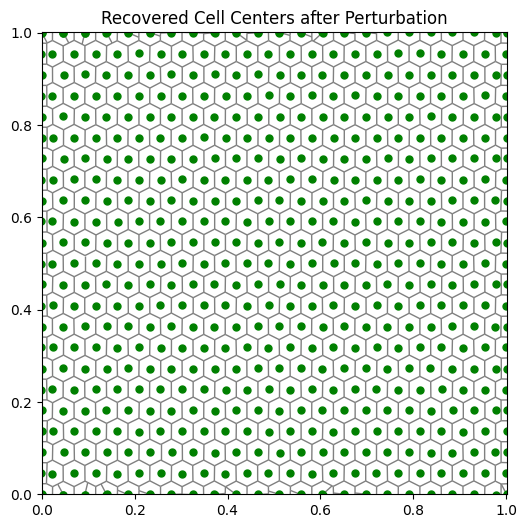

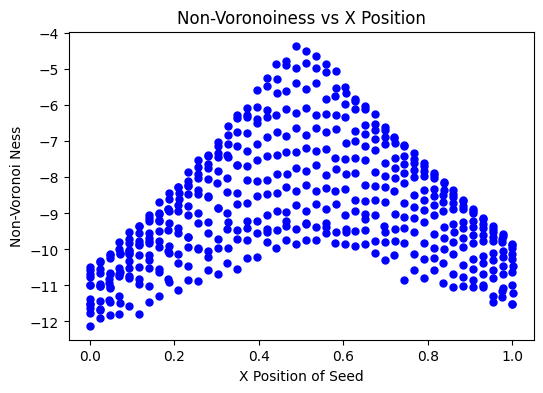

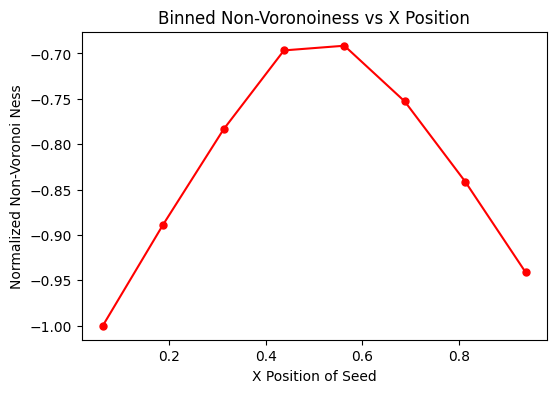

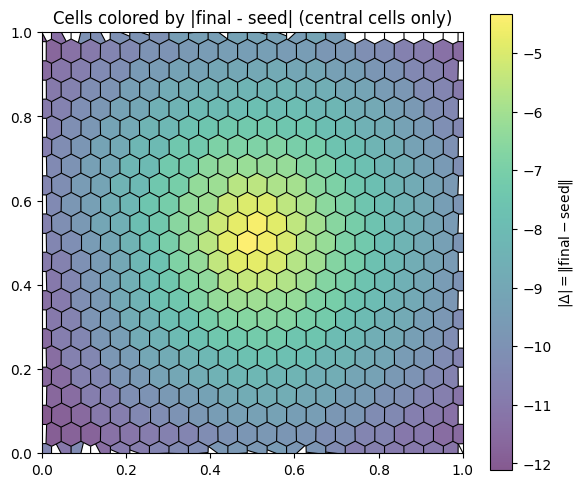

In [ ]:
# HEXAGONAL VORONOI (CENTER VERTEX PERTURBATION)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    # ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()



def choose_nbins(x, method="fd", target_per_bin=30, min_bins=8, max_bins=100):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0: return 1

    xr = x.max() - x.min()
    if xr <= 0: return 1

    if method == "target":
        k = int(np.round(n / max(1, target_per_bin)))
    elif method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    elif method == "sturges":
        k = int(np.ceil(np.log2(n) + 1))
    elif method == "scott":
        s = np.std(x, ddof=1)
        bw = 3.5 * s / (n ** (1/3)) if s > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    elif method == "fd":
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        bw = 2 * iqr / (n ** (1/3)) if iqr > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    else:
        raise ValueError("method must be one of: target, rice, sturges, scott, fd")

    return int(np.clip(k, min_bins, min(max_bins, max(1, k))))

def quantile_edges(x, nbins):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    qs = np.linspace(0, 1, nbins + 1)
    return np.quantile(x, qs)


# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
central_seed_coords, Lx, Ly  = hexagonal_points(500,randomization_strength=0.01)
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
ax.set_xlim(0,Lx)
ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION TO VERTEX AT THE CENTER
max_perturbation_strength = 1/np.sqrt(N_central)*1e-4  # maximum perturbation strength at the right edge
random_direction = np.random.randn(2)
random_direction /= np.linalg.norm(random_direction)
original_vertices = vor.vertices.copy()
vertices_coords = vor.vertices.copy()
centre_vertex_index = np.argmin(np.linalg.norm(vertices_coords - np.array([Lx/2,Ly/2]), axis=1))
vertices_coords[centre_vertex_index] += max_perturbation_strength * random_direction


# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)
nonvoronoiness = np.log10(nonvoronoiness)
nonvoronoiness_of_central_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoi Ness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# BINNING THE NON-VORONOINESS AS FUNCTION OF X POSITION
# n_bins = 20
n_bins = choose_nbins(central_seed_coords[:, 0], method="fd", target_per_bin=8, min_bins=5, max_bins=15)
x_min, x_max = np.min(central_seed_coords[:, 0]), np.max(central_seed_coords[:, 0])
bin_means, bin_edges,_ = binned_statistic(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, statistic='mean', bins=n_bins, range=(x_min, x_max))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_means_norm = bin_means / np.max(np.abs(bin_means))  # normalize by max absolute value
# PLOT Binned Non-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bin_centers, bin_means_norm, 'ro-', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Normalized Non-Voronoi Ness", fontsize=10)
ax.set_title("Binned Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# --- build filled polygons for central seeds only (0..N_central_seeds-1) ---
patches, colors = [], []
for i in range(N_central):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    colors.append(nonvoronoiness[i])            # color by displacement of seed i

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# filled cells colored by |Δ|
pc = PatchCollection(patches, cmap='viridis', alpha=0.65, edgecolor='none')
pc.set_array(np.asarray(colors))
ax.add_collection(pc)

# overlay Voronoi edges for context
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=0.8, point_size=0)

# axes & title
ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_aspect('equal', adjustable='box')
ax.set_title('Cells colored by |final - seed| (central cells only)')

# (optional) annotate central seeds and scatter initial/final markers
# for i, (px, py) in enumerate(central_seed_coords):
#     ax.text(px, py, str(i), fontsize=7, ha='center', va='center',
#             color='white', bbox=dict(boxstyle='round,pad=0.15', fc='black', ec='none', alpha=0.5))
# ax.plot(initial_coords[:, 0], initial_coords[:, 1], 'go', ms=3, label='initial')
# ax.plot(final_coords[:, 0],    final_coords[:, 1],    'rx', ms=3, label='final')
# ax.legend(loc='upper right', fontsize=8)

# colorbar
cbar = plt.colorbar(pc, ax=ax, shrink=0.8)
cbar.set_label(r'$|\Delta| = \|\mathrm{final}-\mathrm{seed}\|$')

plt.tight_layout()
plt.show()







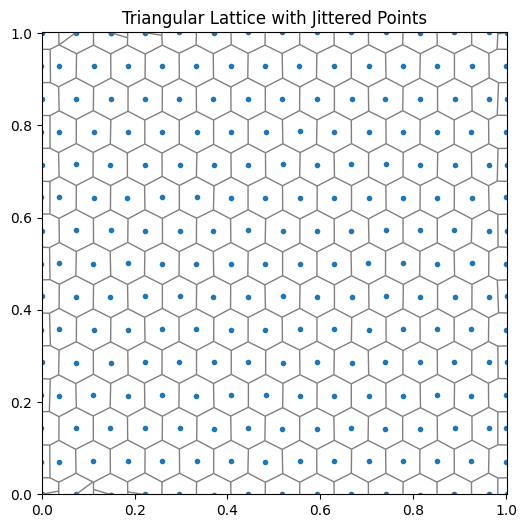

            Converged after 161 iterations


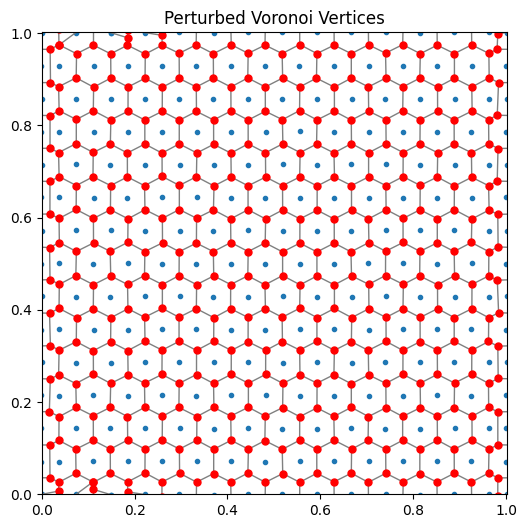

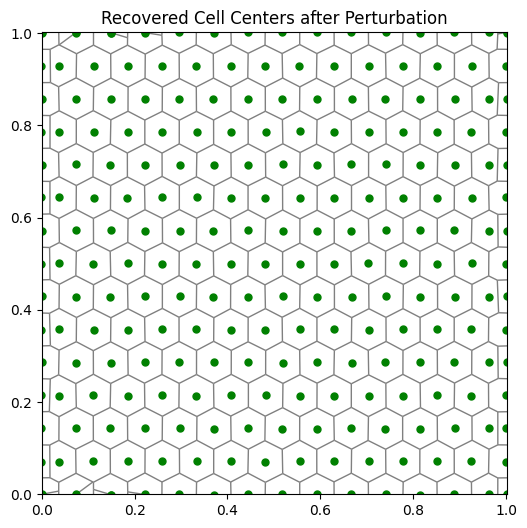

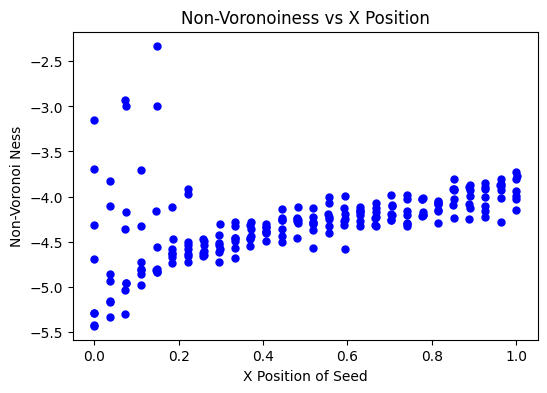

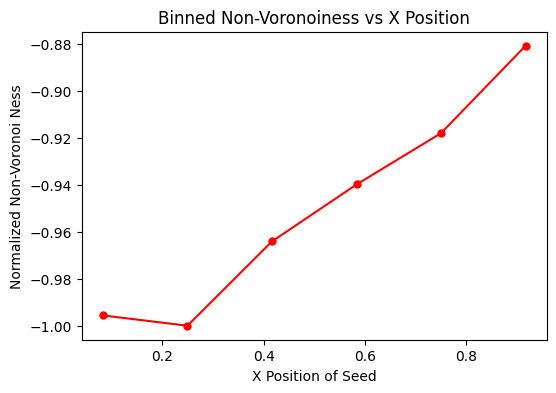

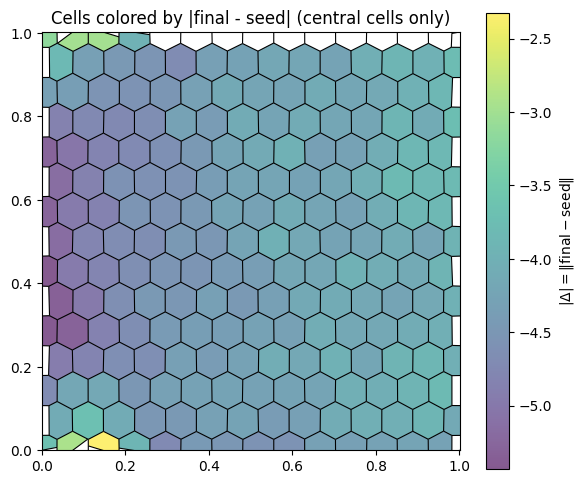

In [ ]:
# HEXAGONAL VORONOI (INCREASING PERTURBATION ACCORDING TO X POSITION)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    # ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()



def choose_nbins(x, method="fd", target_per_bin=30, min_bins=8, max_bins=100):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0: return 1

    xr = x.max() - x.min()
    if xr <= 0: return 1

    if method == "target":
        k = int(np.round(n / max(1, target_per_bin)))
    elif method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    elif method == "sturges":
        k = int(np.ceil(np.log2(n) + 1))
    elif method == "scott":
        s = np.std(x, ddof=1)
        bw = 3.5 * s / (n ** (1/3)) if s > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    elif method == "fd":
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        bw = 2 * iqr / (n ** (1/3)) if iqr > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    else:
        raise ValueError("method must be one of: target, rice, sturges, scott, fd")

    return int(np.clip(k, min_bins, min(max_bins, max(1, k))))

def quantile_edges(x, nbins):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    qs = np.linspace(0, 1, nbins + 1)
    return np.quantile(x, qs)


# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
central_seed_coords, Lx, Ly  = hexagonal_points(200,randomization_strength=0.01)
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
ax.set_xlim(0,Lx)
ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION (INCREASING ACCORDING TO X POSITION)
max_perturbation_strength = 1/np.sqrt(N_central)*1e-4  # maximum perturbation strength at the right edge
original_vertices = vor.vertices.copy()
vertices_coords = vor.vertices.copy()
for i in range(len(vertices_coords)):
    if vertices_coords[i,0]<0 or vertices_coords[i,0]>Lx or vertices_coords[i,1]<0 or vertices_coords[i,1]>Ly:
        continue  # only perturb vertices inside the box
    x, y = vertices_coords[i]
    t = x / Lx
    local_perturbation_strength = t * max_perturbation_strength
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[i] += local_perturbation_strength * random_direction


# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)
nonvoronoiness = np.log10(nonvoronoiness)
nonvoronoiness_of_central_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoi Ness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# BINNING THE NON-VORONOINESS AS FUNCTION OF X POSITION
# n_bins = 20
n_bins = choose_nbins(central_seed_coords[:, 0], method="fd", target_per_bin=8, min_bins=5, max_bins=15)
x_min, x_max = np.min(central_seed_coords[:, 0]), np.max(central_seed_coords[:, 0])
bin_means, bin_edges,_ = binned_statistic(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, statistic='mean', bins=n_bins, range=(x_min, x_max))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_means_norm = bin_means / np.max(np.abs(bin_means))  # normalize by max absolute value
# PLOT Binned Non-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bin_centers, bin_means_norm, 'ro-', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Normalized Non-Voronoi Ness", fontsize=10)
ax.set_title("Binned Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# --- build filled polygons for central seeds only (0..N_central_seeds-1) ---
patches, colors = [], []
for i in range(N_central):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    colors.append(nonvoronoiness[i])            # color by displacement of seed i

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# filled cells colored by |Δ|
pc = PatchCollection(patches, cmap='viridis', alpha=0.65, edgecolor='none')
pc.set_array(np.asarray(colors))
ax.add_collection(pc)

# overlay Voronoi edges for context
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=0.8, point_size=0)

# axes & title
ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_aspect('equal', adjustable='box')
ax.set_title('Cells colored by |final - seed| (central cells only)')

# (optional) annotate central seeds and scatter initial/final markers
# for i, (px, py) in enumerate(central_seed_coords):
#     ax.text(px, py, str(i), fontsize=7, ha='center', va='center',
#             color='white', bbox=dict(boxstyle='round,pad=0.15', fc='black', ec='none', alpha=0.5))
# ax.plot(initial_coords[:, 0], initial_coords[:, 1], 'go', ms=3, label='initial')
# ax.plot(final_coords[:, 0],    final_coords[:, 1],    'rx', ms=3, label='final')
# ax.legend(loc='upper right', fontsize=8)

# colorbar
cbar = plt.colorbar(pc, ax=ax, shrink=0.8)
cbar.set_label(r'$|\Delta| = \|\mathrm{final}-\mathrm{seed}\|$')

plt.tight_layout()
plt.show()







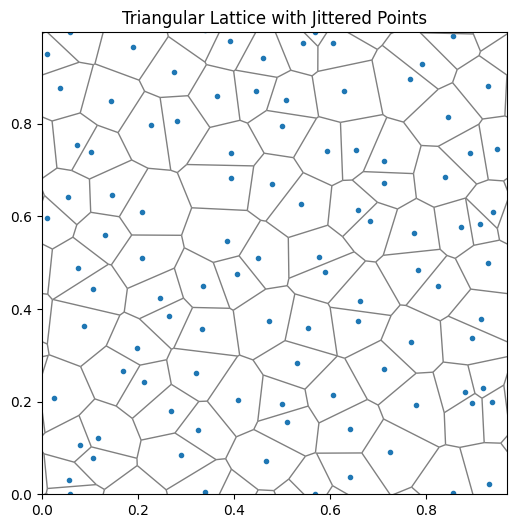

            Converged after 129 iterations


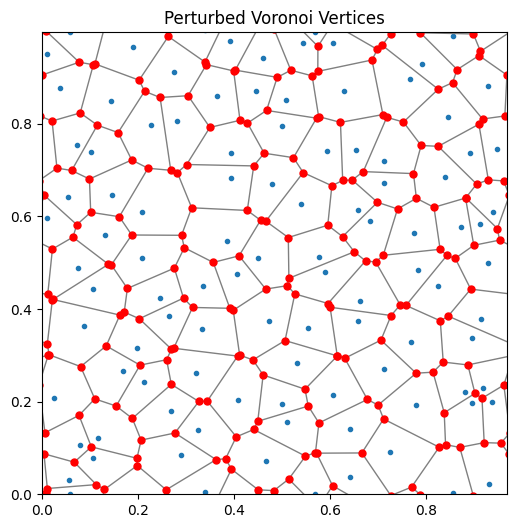

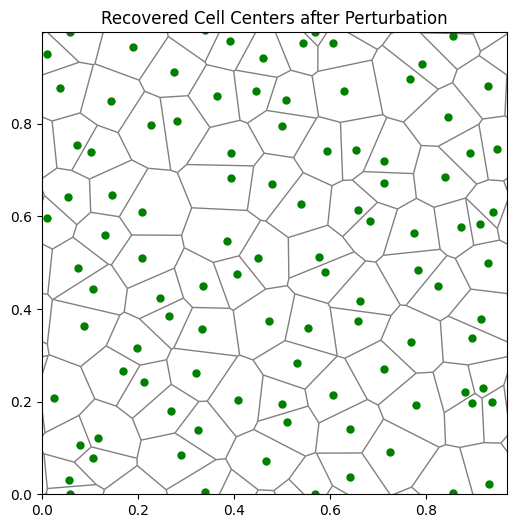

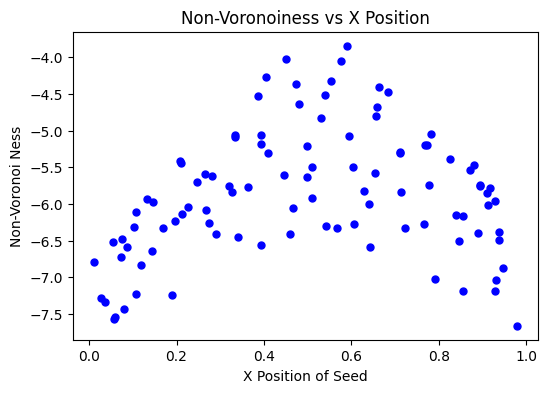

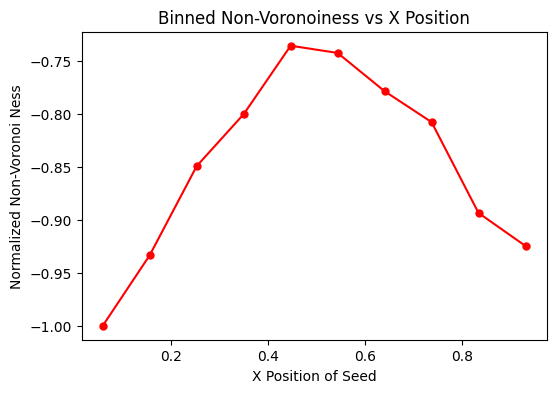

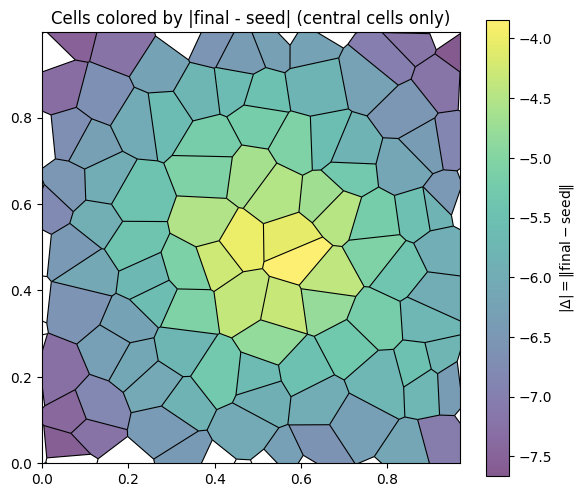

In [ ]:
# JITTERED VORONOI FOR RANDOM INITIAL POINTS (CENTER VERTEX PERTURBATION)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    # ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()



def choose_nbins(x, method="fd", target_per_bin=30, min_bins=8, max_bins=100):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0: return 1

    xr = x.max() - x.min()
    if xr <= 0: return 1

    if method == "target":
        k = int(np.round(n / max(1, target_per_bin)))
    elif method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    elif method == "sturges":
        k = int(np.ceil(np.log2(n) + 1))
    elif method == "scott":
        s = np.std(x, ddof=1)
        bw = 3.5 * s / (n ** (1/3)) if s > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    elif method == "fd":
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        bw = 2 * iqr / (n ** (1/3)) if iqr > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    else:
        raise ValueError("method must be one of: target, rice, sturges, scott, fd")

    return int(np.clip(k, min_bins, min(max_bins, max(1, k))))

def quantile_edges(x, nbins):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    qs = np.linspace(0, 1, nbins + 1)
    return np.quantile(x, qs)


def jittered_grid(N, rng=None):
    rng = np.random.default_rng(rng)
    n = int(np.sqrt(N))
    m = int(np.ceil(N / n))
    xs = (np.arange(n)[:,None] + rng.random((n,m))) / n
    ys = (np.arange(m)[None,:] + rng.random((n,m))) / m
    P  = np.stack([xs, ys], axis=-1).reshape(-1,2)[:N]
    return np.clip(P, 0, 1)

# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
# central_seed_coords, Lx, Ly  = hexagonal_points(500,randomization_strength=0.01)
central_seed_coords = jittered_grid(100)  # generate 300 jittered points in [0,1]x[0,1]
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
ax.set_xlim(0,Lx)
ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION TO VERTEX AT THE CENTER
max_perturbation_strength = 1/np.sqrt(N_central)*1e-4  # maximum perturbation strength at the right edge
random_direction = np.random.randn(2)
random_direction /= np.linalg.norm(random_direction)
original_vertices = vor.vertices.copy()
vertices_coords = vor.vertices.copy()
centre_vertex_index = np.argmin(np.linalg.norm(vertices_coords - np.array([Lx/2,Ly/2]), axis=1))
vertices_coords[centre_vertex_index] += max_perturbation_strength * random_direction


# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)
nonvoronoiness = np.log10(nonvoronoiness)
nonvoronoiness_of_central_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoi Ness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# BINNING THE NON-VORONOINESS AS FUNCTION OF X POSITION
n_bins = 10
# n_bins = choose_nbins(central_seed_coords[:, 0], method="fd", target_per_bin=8, min_bins=5, max_bins=15)
x_min, x_max = np.min(central_seed_coords[:, 0]), np.max(central_seed_coords[:, 0])
bin_means, bin_edges,_ = binned_statistic(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, statistic='mean', bins=n_bins, range=(x_min, x_max))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_means_norm = bin_means / np.max(np.abs(bin_means))  # normalize by max absolute value
# PLOT Binned Non-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bin_centers, bin_means_norm, 'ro-', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Normalized Non-Voronoi Ness", fontsize=10)
ax.set_title("Binned Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# --- build filled polygons for central seeds only (0..N_central_seeds-1) ---
patches, colors = [], []
for i in range(N_central):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    colors.append(nonvoronoiness[i])            # color by displacement of seed i

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# filled cells colored by |Δ|
pc = PatchCollection(patches, cmap='viridis', alpha=0.65, edgecolor='none')
pc.set_array(np.asarray(colors))
ax.add_collection(pc)

# overlay Voronoi edges for context
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=0.8, point_size=0)

# axes & title
ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_aspect('equal', adjustable='box')
ax.set_title('Cells colored by |final - seed| (central cells only)')

# (optional) annotate central seeds and scatter initial/final markers
# for i, (px, py) in enumerate(central_seed_coords):
#     ax.text(px, py, str(i), fontsize=7, ha='center', va='center',
#             color='white', bbox=dict(boxstyle='round,pad=0.15', fc='black', ec='none', alpha=0.5))
# ax.plot(initial_coords[:, 0], initial_coords[:, 1], 'go', ms=3, label='initial')
# ax.plot(final_coords[:, 0],    final_coords[:, 1],    'rx', ms=3, label='final')
# ax.legend(loc='upper right', fontsize=8)

# colorbar
cbar = plt.colorbar(pc, ax=ax, shrink=0.8)
cbar.set_label(r'$|\Delta| = \|\mathrm{final}-\mathrm{seed}\|$')

plt.tight_layout()
plt.show()







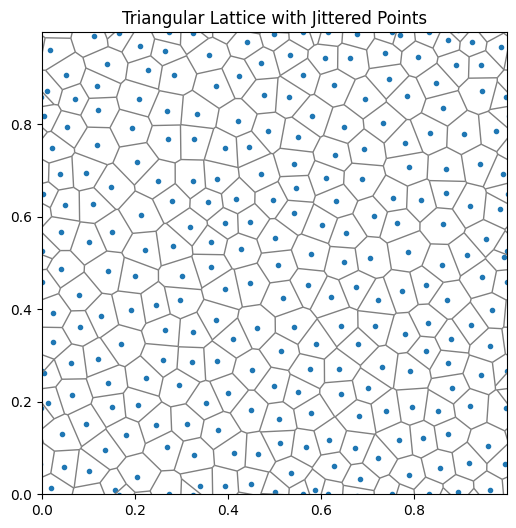

            Converged after 121 iterations


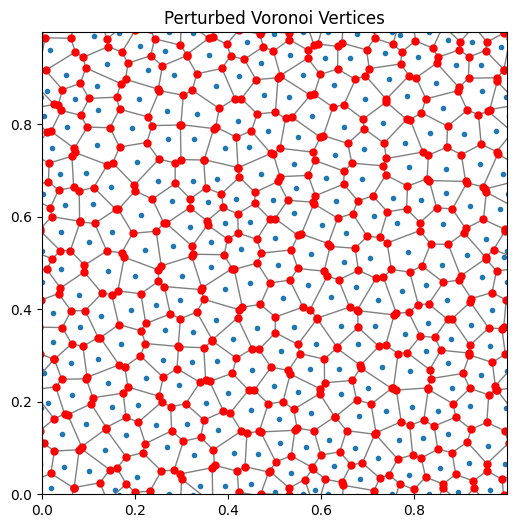

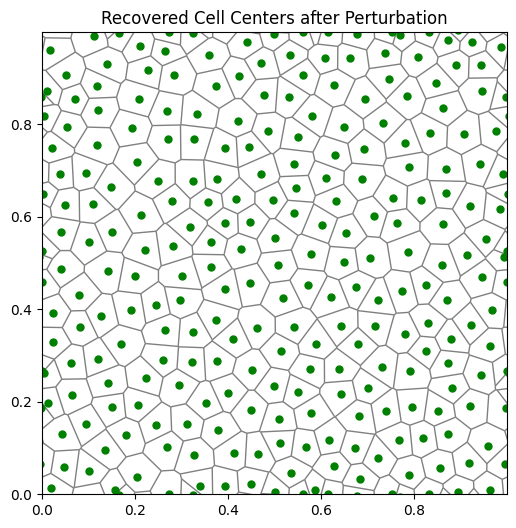

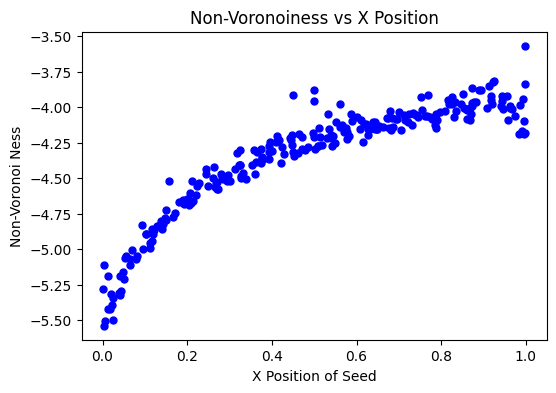

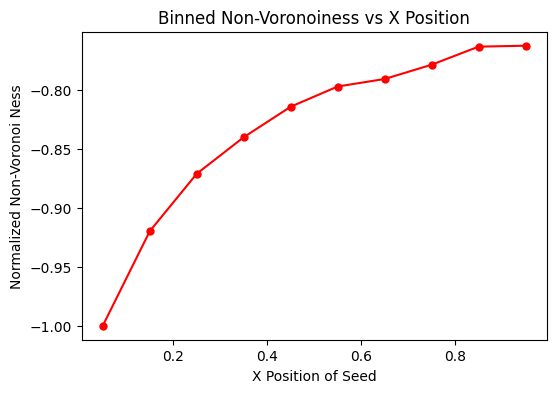

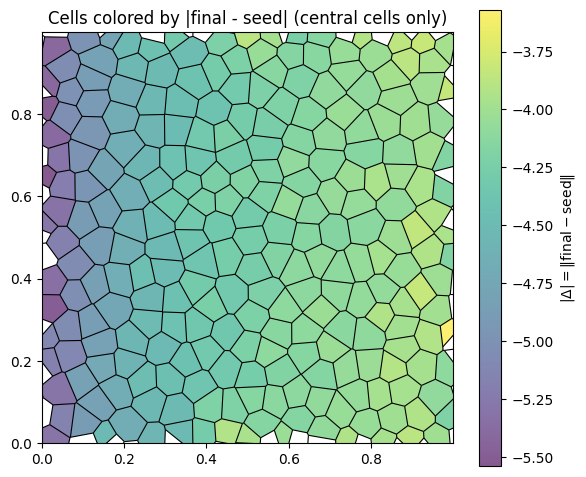

In [81]:
# JITTERED VORONOI FOR RANDOM INITIAL POINTS (INCREASING PERTURBATION ACCORDING TO X POSITION)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton

def make_triangular_lattice_squareish(
    N_target=None,
    a=1.0,
    prefer_more=True,
    *,
    # Jitter controls
    jitter_frac=0.0,           # e.g. 0.05 means σ = 0.05 * a (if ramp is None)
    ramp=None,                 # dict like {"axis": "x", "left": 0.0, "right": 0.10} in *fractions of a*
    jitter_kind="gaussian",    # "gaussian" or "uniform"
    clip_sigma=2.5,            # clip gaussian at ±clip_sigma*σ
    periodic=True,             # wrap back into [0,Lx)×[0,Ly) if True; else clip to box
    seed=None
):
    """
    Returns (pts, Lx, Ly, nx, ny, N). If jitter_frac>0 or ramp is given, points are 'jiggled'.
    ramp lets you increase jitter strength from left→right (or bottom→top) in box coordinates.
    """
    rng = np.random.default_rng(seed)
    root3 = np.sqrt(3.0)

    if N_target is None:
        N_target = 1200

    # choose (nx, ny) ~ square-ish
    ny_est = int(max(1, round(np.sqrt((2.0 / root3) * N_target))))
    candidates = []
    for ny in range(max(1, ny_est - 200), ny_est + 201):
        nx = max(1, int(round((root3 / 2.0) * ny)))
        N = nx * ny
        if prefer_more and N < N_target:
            nx2 = int(np.ceil(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        elif (not prefer_more) and N > N_target:
            nx2 = int(np.floor(N_target / ny))
            nx2 = max(nx2, 1)
            nx, N = nx2, nx2 * ny
        if N <= 0:
            continue
        Lx = nx * a
        Ly = ny * (root3 / 2.0) * a
        aspect = max(Lx, Ly) / min(Lx, Ly)
        cost = (aspect - 1.0) ** 2 + 1e-6 * abs(N - N_target)
        candidates.append((cost, nx, ny, N, Lx, Ly))

    if not candidates:
        raise RuntimeError("Could not find suitable (nx, ny).")

    _, nx, ny, N, Lx, Ly = min(candidates, key=lambda t: t[0])

    # perfect lattice
    pts = np.zeros((N, 2), float)
    idx = 0
    for j in range(ny):
        y = j * (root3 / 2.0) * a
        xoff = 0.5 * a if (j % 2 == 1) else 0.0
        for i in range(nx):
            x = i * a + xoff
            pts[idx] = (x, y)
            idx += 1
    assert idx == N

    # ----- JITTER -----
    # Decide local jitter strength (σ or half-range) per point.
    # 1) base (constant) strength:
    base = float(jitter_frac) * a

    # 2) optional ramp (e.g., left→right or bottom→top)
    #    ramp in fractions of 'a', converted to absolute length here.
    if ramp is not None:
        axis = ramp.get("axis", "x").lower()
        v0 = float(ramp.get("left" if axis == "x" else "bottom", 0.0)) * a
        v1 = float(ramp.get("right" if axis == "x" else "top",    base / a)) * a
        # position in [0,1] along chosen axis
        if axis == "x":
            t = pts[:, 0] / Lx if Lx > 0 else 0.0
        elif axis == "y":
            t = pts[:, 1] / Ly if Ly > 0 else 0.0
        else:
            raise ValueError("ramp['axis'] must be 'x' or 'y'")
        local_amp = (1.0 - t) * v0 + t * v1
    else:
        local_amp = np.full(N, base)

    if (local_amp > 0).any():
        if jitter_kind == "gaussian":
            # per-point σ = local_amp; clip long tails to keep cells well-formed
            dx = rng.normal(0.0, 1.0, size=N)
            dy = rng.normal(0.0, 1.0, size=N)
            # clip to ±clip_sigma
            dx = np.clip(dx, -clip_sigma, clip_sigma) * local_amp
            dy = np.clip(dy, -clip_sigma, clip_sigma) * local_amp
        elif jitter_kind == "uniform":
            # per-point half-range = local_amp
            dx = rng.uniform(-1.0, 1.0, size=N) * local_amp
            dy = rng.uniform(-1.0, 1.0, size=N) * local_amp
        else:
            raise ValueError("jitter_kind must be 'gaussian' or 'uniform'")

        pts[:, 0] += dx
        pts[:, 1] += dy

        # Keep points in the box
        if periodic:
            # Wrap (good if you use periodic images later)
            if Lx > 0:
                pts[:, 0] %= Lx
            if Ly > 0:
                pts[:, 1] %= Ly
        else:
            # Hard clip to the domain
            pts[:, 0] = np.clip(pts[:, 0], 0.0, max(Lx - 1e-12, 0.0))
            pts[:, 1] = np.clip(pts[:, 1], 0.0, max(Ly - 1e-12, 0.0))

        # Optional: remove net translation to keep mean position unchanged
        # pts -= pts.mean(axis=0)

    return pts, Lx, Ly, nx, ny, N

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def plot_colored_voronoi(vor, nonvoronoiness,Lx,Ly, title=None, cmap='viridis'):
    """
    Plot Voronoi cells colored by a provided per-seed scalar value.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi
        Computed Voronoi structure
    nonvoronoiness : array-like
        Array of scalar values for coloring each valid region
    title : str, optional
        Plot title
    cmap : str, optional
        Colormap to use
    """

    patches, colors = [], []
    N_real = len(vor.points)

    # Create polygons for each non-infinite region
    for i in range(N_real):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            continue
        polygon = np.array([vor.vertices[j] for j in region])
        patches.append(Polygon(polygon, closed=True))
        colors.append(nonvoronoiness[i])

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))

    pc = PatchCollection(
        patches,
        cmap=cmap,
        edgecolor='none',
        alpha=0.8
    )
    pc.set_array(np.array(colors))
    ax.add_collection(pc)

    # Overlay Voronoi edges
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                    line_colors='black', line_width=0.4, line_alpha=0.6)

    # Styling
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    # ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
    ax.set_title(title if title else 'Voronoi Cell Plot', fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()



def choose_nbins(x, method="fd", target_per_bin=30, min_bins=8, max_bins=100):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0: return 1

    xr = x.max() - x.min()
    if xr <= 0: return 1

    if method == "target":
        k = int(np.round(n / max(1, target_per_bin)))
    elif method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    elif method == "sturges":
        k = int(np.ceil(np.log2(n) + 1))
    elif method == "scott":
        s = np.std(x, ddof=1)
        bw = 3.5 * s / (n ** (1/3)) if s > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    elif method == "fd":
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        bw = 2 * iqr / (n ** (1/3)) if iqr > 0 else xr
        k = int(np.ceil(xr / max(bw, 1e-12)))
    else:
        raise ValueError("method must be one of: target, rice, sturges, scott, fd")

    return int(np.clip(k, min_bins, min(max_bins, max(1, k))))

def quantile_edges(x, nbins):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    qs = np.linspace(0, 1, nbins + 1)
    return np.quantile(x, qs)


def jittered_grid(N, rng=None):
    rng = np.random.default_rng(rng)
    n = int(np.sqrt(N))
    m = int(np.ceil(N / n))
    xs = (np.arange(n)[:,None] + rng.random((n,m))) / n
    ys = (np.arange(m)[None,:] + rng.random((n,m))) / m
    P  = np.stack([xs, ys], axis=-1).reshape(-1,2)[:N]
    return np.clip(P, 0, 1)


def poisson_disk(N, r=None, k=30, rng=None):
    """
    Bridson algorithm in [0,1]^2. If r not given, pick ~beta/sqrt(N).
    Returns up to N points (may be slightly less for strict r).
    """
    rng = np.random.default_rng(rng)
    if r is None:
        r = 0.85 / np.sqrt(N)
    r2, R = r*r, 2*r
    cell = r / np.sqrt(2)
    nx = int(np.ceil(1/cell)); ny = nx
    grid = -np.ones((nx, ny), dtype=int)

    def grid_idx(p):
        return int(p[0]/cell), int(p[1]/cell)

    pts = []
    active = []

    # seed
    p0 = rng.random(2)
    pts.append(p0); active.append(0)
    ix, iy = grid_idx(p0)
    grid[ix, iy] = 0

    while active and len(pts) < N:
        i = rng.choice(active)
        base = pts[i]
        placed = False
        for _ in range(k):
            ang = rng.random()*2*np.pi
            rad = r * (1 + rng.random())
            cand = base + rad*np.array([np.cos(ang), np.sin(ang)])
            if not (0 <= cand[0] < 1 and 0 <= cand[1] < 1):
                continue
            gx, gy = grid_idx(cand)
            ok = True
            for ix in range(max(gx-2,0), min(gx+3,nx)):
                for iy in range(max(gy-2,0), min(gy+3,ny)):
                    j = grid[ix,iy]
                    if j >= 0 and np.sum((pts[j]-cand)**2) < r2:
                        ok = False; break
                if not ok: break
            if ok:
                grid[gx,gy] = len(pts)
                pts.append(cand); active.append(len(pts)-1)
                placed = True
                if len(pts) >= N: break
        if not placed:
            active.remove(i)

    return np.array(pts)


def lhs(N, d=2, rng=None):
    rng = np.random.default_rng(rng)
    u = (rng.random((N,d)) + np.arange(N)[:,None]) / N
    for j in range(d):
        rng.shuffle(u[:,j])
    return u  # already in [0,1]^d


N = 300
# GENERATING INITIAL VORONOI DIAGRAM
# points,Lx,Ly,nx,ny,N = make_triangular_lattice_squareish(N_target=100, a=1.0, prefer_more=True,jitter_frac=0.00)
# central_seed_coords = np.random.rand(300,2)
# central_seed_coords, Lx, Ly  = hexagonal_points(500,randomization_strength=0.01)
central_seed_coords = jittered_grid(N)  # generate 300 jittered points in [0,1]x[0,1]
central_seed_coords = poisson_disk(N, r=0.9/np.sqrt(N), rng=42)  # generate poisson-disk points in [0,1]x[0,1]
# central_seed_coords = lhs(100)  # generate latin-hypercube points in [0,1]x[0,1]
Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])

# Masks relative to box center
mx_left  = central_seed_coords[:, 0] >  Lx/2  # shift by (-Lx, 0)
mx_right = central_seed_coords[:, 0] <  Lx/2  # shift by (+Lx, 0)
my_down  = central_seed_coords[:, 1] >  Ly/2  # shift by (0, -Ly)
my_up    = central_seed_coords[:, 1] <  Ly/2  # shift by (0, +Ly)

# 1) originals (first N)
coords = [central_seed_coords]

# 2) left/right shifts
coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))

# 3) up/down shifts
coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))

# 4) corner shifts (apply both x and y)
coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))

extended_seed_coords = np.vstack(coords)

points = extended_seed_coords

# index of central seeds in the extended array, first N points
N_central = len(central_seed_coords)
central_seed_indices = np.arange(N_central)


vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.set_title("Triangular Lattice with Jittered Points", fontsize=12)
ax.set_xlim(0,Lx)
ax.set_ylim(0,Ly)
plt.show()


# APPLY RANDOM PERTURBATION (INCREASING ACCORDING TO X POSITION)
max_perturbation_strength = 1/np.sqrt(N_central)*1e-4  # maximum perturbation strength at the right edge
original_vertices = vor.vertices.copy()
vertices_coords = vor.vertices.copy()
for i in range(len(vertices_coords)):
    if vertices_coords[i,0]<0 or vertices_coords[i,0]>Lx or vertices_coords[i,1]<0 or vertices_coords[i,1]>Ly:
        continue  # only perturb vertices inside the box
    x, y = vertices_coords[i]
    t = x / Lx
    local_perturbation_strength = t * max_perturbation_strength
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    vertices_coords[i] += local_perturbation_strength * np.array([1,0])


# PLOT PERTURBED VERTICES ON TOP OF ORIGINAL VORONOI 
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(vertices_coords[:, 0], vertices_coords[:, 1], 'ro', label='Perturbed Vertices', markersize=5)
ax.set_title("Perturbed Voronoi Vertices", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)


# INVERSE VORONOI RECONSTRUCTION
from Main_Function import fun_vor_main
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)


# PLOT RECOVERED CELL CENTERS ON TOP OF ORIGINAL VORONOI
fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='gray')
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered Cell Centers', markersize=5)
ax.set_title("Recovered Cell Centers after Perturbation", fontsize=12)
ax.set_xlim(0,Lx); ax.set_ylim(0,Ly)
plt.show()

# CALCULATE NON-VORONOINESS PER SEED
nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)
nonvoronoiness = np.log10(nonvoronoiness)
nonvoronoiness_of_central_seeds = np.array(nonvoronoiness)[central_seed_indices]
# PLOT NON-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, 'bo', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Non-Voronoi Ness", fontsize=10)
ax.set_title("Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# BINNING THE NON-VORONOINESS AS FUNCTION OF X POSITION
n_bins = 10
# n_bins = choose_nbins(central_seed_coords[:, 0], method="fd", target_per_bin=8, min_bins=5, max_bins=15)
x_min, x_max = np.min(central_seed_coords[:, 0]), np.max(central_seed_coords[:, 0])
bin_means, bin_edges,_ = binned_statistic(central_seed_coords[:, 0], nonvoronoiness_of_central_seeds, statistic='mean', bins=n_bins, range=(x_min, x_max))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_means_norm = bin_means / np.max(np.abs(bin_means))  # normalize by max absolute value
# PLOT Binned Non-VORONOINESS AS FUNCTION OF X POSITION
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bin_centers, bin_means_norm, 'ro-', markersize=5)
ax.set_xlabel("X Position of Seed", fontsize=10)
ax.set_ylabel("Normalized Non-Voronoi Ness", fontsize=10)
ax.set_title("Binned Non-Voronoiness vs X Position", fontsize=12)
plt.show()


# --- build filled polygons for central seeds only (0..N_central_seeds-1) ---
patches, colors = [], []
for i in range(N_central):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    colors.append(nonvoronoiness[i])            # color by displacement of seed i

# --- plot ---
fig, ax = plt.subplots(figsize=(6, 6))

# filled cells colored by |Δ|
pc = PatchCollection(patches, cmap='viridis', alpha=0.65, edgecolor='none')
pc.set_array(np.asarray(colors))
ax.add_collection(pc)

# overlay Voronoi edges for context
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='k', line_width=0.8, point_size=0)

# axes & title
ax.set_xlim(0, Lx); ax.set_ylim(0, Ly); ax.set_aspect('equal', adjustable='box')
ax.set_title('Cells colored by |final - seed| (central cells only)')

# (optional) annotate central seeds and scatter initial/final markers
# for i, (px, py) in enumerate(central_seed_coords):
#     ax.text(px, py, str(i), fontsize=7, ha='center', va='center',
#             color='white', bbox=dict(boxstyle='round,pad=0.15', fc='black', ec='none', alpha=0.5))
# ax.plot(initial_coords[:, 0], initial_coords[:, 1], 'go', ms=3, label='initial')
# ax.plot(final_coords[:, 0],    final_coords[:, 1],    'rx', ms=3, label='final')
# ax.legend(loc='upper right', fontsize=8)

# colorbar
cbar = plt.colorbar(pc, ax=ax, shrink=0.8)
cbar.set_label(r'$|\Delta| = \|\mathrm{final}-\mathrm{seed}\|$')

plt.tight_layout()
plt.show()







PARALLELIZED VERSIONS

In [7]:
# HEXAGONAL VORONOI (CENTER VERTEX PERTURBATION)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton
import os
from joblib import Parallel, delayed

def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices,N_central):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for i in range(N_central):
        key = f'sub_dict_{i}'
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            # print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            # mirror m_final across the common edge
            common_vertex1_coord = vertices[common_edges[0][0]]
            common_vertex2_coord = vertices[common_edges[0][1]]
            # Reflect across the common edge
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

def hexagonal_points(n_points,randomization_strength=0.0):
    """
    Generate n_points hexagonally packed points within [0,1]×[0,1].

    Returns:
        points : (n_points, 2) numpy array in the range [0,1]
        Lx     : float - physical width of the hexagonal lattice before normalization
        Ly     : float - physical height of the hexagonal lattice before normalization
    """

    # Estimate lattice counts in x and y
    n_x = int(np.sqrt(n_points))
    n_y = int(np.ceil(n_points / n_x))

    # Lattice spacing before normalization
    ax = 1.0
    ay = np.sqrt(3) / 2.0 * ax

    # Create grid
    pts = []
    for j in range(n_y):
        for i in range(n_x):
            x = i * ax + (0.5 * ax if (j % 2) else 0.0)
            y = j * ay
            pts.append([x, y])
            if len(pts) >= n_points:
                break
        if len(pts) >= n_points:
            break

    pts = np.array(pts)

    # Apply specified randomization
    for i in range(len(pts)):
        random_direction = np.random.randn(2)
        random_direction /= np.linalg.norm(random_direction)
        pts[i] += randomization_strength * random_direction

    # Compute actual bounding dimensions
    Lx = (n_x - 1) * ax + 0.5 * ax  # half shift for odd rows
    Ly = (n_y - 1) * ay

    # Normalize to [0,1]^2
    if Lx > 0: pts[:,0] /= Lx
    if Ly > 0: pts[:,1] /= Ly

    return pts, Lx, Ly



def single_test(i,N_points, perturbation_strength):

    # GENERATE INITIAL RANDOM POINTS FOR HEXAGONAL VORONOI
    central_seed_coords, Lx, Ly  = hexagonal_points(N_points,randomization_strength=0.01)
    Lx = np.max(central_seed_coords[:, 0]) - np.min(central_seed_coords[:, 0])
    Ly = np.max(central_seed_coords[:, 1]) - np.min(central_seed_coords[:, 1])


    # GENERATE EXTENDED POINTS FOR PERIODICITY
    # Masks relative to box center
    mx_left  = central_seed_coords[:, 0] >  Lx/2
    mx_right = central_seed_coords[:, 0] <  Lx/2
    my_down  = central_seed_coords[:, 1] >  Ly/2
    my_up    = central_seed_coords[:, 1] <  Ly/2
    # 1) originals (first N)
    coords = [central_seed_coords]
    # 2) left/right shifts
    coords.append(central_seed_coords[mx_left]  + np.array([-Lx, 0.0]))
    coords.append(central_seed_coords[mx_right] + np.array([+Lx, 0.0]))
    # 3) up/down shifts
    coords.append(central_seed_coords[my_down]  + np.array([0.0, -Ly]))
    coords.append(central_seed_coords[my_up]    + np.array([0.0, +Ly]))
    # 4) corner shifts (apply both x and y)
    coords.append(central_seed_coords[mx_left  & my_down] + np.array([-Lx, -Ly]))
    coords.append(central_seed_coords[mx_left  & my_up]   + np.array([-Lx, +Ly]))
    coords.append(central_seed_coords[mx_right & my_down] + np.array([+Lx, -Ly]))
    coords.append(central_seed_coords[mx_right & my_up]   + np.array([+Lx, +Ly]))
    extended_seed_coords = np.vstack(coords)
    points = extended_seed_coords
    # index of central seeds in the extended array, first N points
    N_central = len(central_seed_coords)
    central_seed_indices = np.arange(N_central)


    # CREATE VORONOI DIAGRAM
    vor = Voronoi(points)

    # STORE ORIGINAL VERTICES
    original_vertices = vor.vertices.copy()


    # APPLY PERTURBATION IN A RANDOM DIRECTION TO THE VERTEX AT THE CENTER
    vertices_coords = vor.vertices.copy()
    max_perturbation_strength = perturbation_strength  # maximum perturbation strength at the right edge
    random_direction = np.random.randn(2)
    random_direction /= np.linalg.norm(random_direction)
    centre_vertex_index = np.argmin(np.linalg.norm(vertices_coords - np.array([Lx/2,Ly/2]), axis=1))
    vertices_coords[centre_vertex_index] += max_perturbation_strength * random_direction

    # RECOVER CELL CENTERS
    from Main_Function import fun_vor_main
    (explicit_voronoi_perturbed, 
     vertices_perturbed, 
     cell_centers_perturbed, 
     distance_original_list_perturbed, 
     distance_from_found_to_previous_perturbed) = fun_vor_main(vor,points,vertices_coords)
    
    # CALCULATE NON-VORONOINESS PER SEED
    nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,original_vertices,N_central)

    results = {
        'nonvoronoiness': nonvoronoiness,
        'central_seed_coords': central_seed_coords
    }

    return results


# BATCH RUNNER

number_of_tests = 50 # how many random realizations to run
number_of_points = 300 # number of central seeds in each realization
number_of_perturbations = 10 # number of different perturbation strengths
perturbations = np.linspace(1e-4, 1e-2, number_of_perturbations) * (1.0/np.sqrt(number_of_points)) # perturbation strengths to test

# Creating an output directory for saving results
output_dir = "hexagonal_center_vertex_perturbation_results"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in the directory: {output_dir}")
print(f'Running {number_of_tests} tests for each of the {number_of_perturbations} perturbation strengths...')

for p_idx, p in enumerate(perturbations):
    print(f'\n Starting tests for perturbation strength {p:.2e} ({p_idx+1}/{number_of_perturbations})')

    # Parallelize tests for this perturbation
    results = Parallel(n_jobs=-1,backend='loky')(
        delayed(single_test)(i,number_of_points, p) for i in range(number_of_tests))
    
    # Save results to file
    fname = os.path.join(output_dir, f'hexagonal_center_vertex_perturbation_results_p{p_idx:02d}.npy')
    np.save(fname, results, allow_pickle=True)

    print(f' Saved {number_of_tests} tests for perturbation {p:.2e} to {fname}')

print('\n Done! .npy is now available in the output directory for each perturbation strength.')

Results will be saved in the directory: hexagonal_center_vertex_perturbation_results
Running 50 tests for each of the 10 perturbation strengths...

 Starting tests for perturbation strength 5.77e-06 (1/10)
 Saved 50 tests for perturbation 5.77e-06 to hexagonal_center_vertex_perturbation_results\hexagonal_center_vertex_perturbation_results_p00.npy

 Starting tests for perturbation strength 6.93e-05 (2/10)


KeyboardInterrupt: 

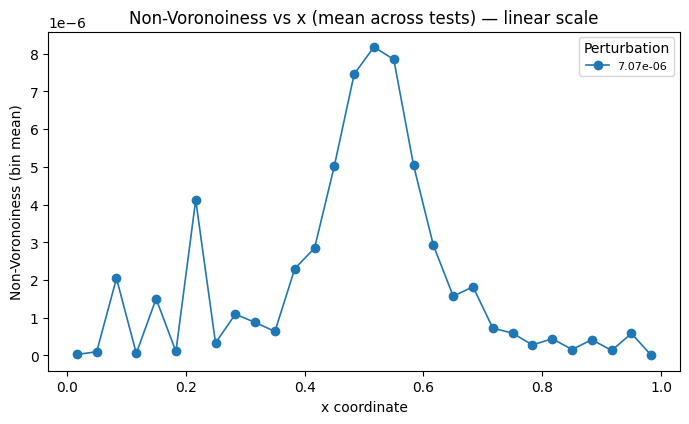

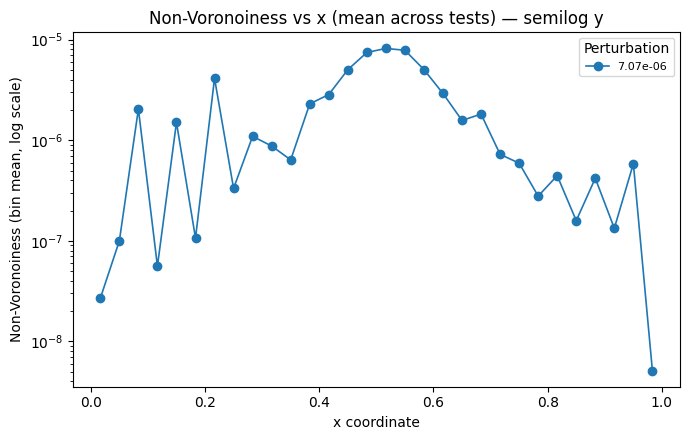

In [6]:
import numpy as np
import os
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

# ---- settings ----
n_bins = 30
bins = np.linspace(0.0, 1.0, n_bins + 1)   # since your coords are ~[0,1]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
eps = 1e-16  # for safe log plots

# containers
per_p_mean_bin = []   # shape -> (n_perturbations, n_bins)

for p_idx, p in enumerate(perturbations):
    # support both filename patterns
    fname1 = os.path.join(output_dir, f'hexagonal_center_vertex_perturbation_results_p{p_idx:02d}_{p:.3e}.npy')
    fname2 = os.path.join(output_dir, f'hexagonal_center_vertex_perturbation_results_p{p_idx:02d}.npy')
    fname = fname1 if os.path.exists(fname1) else fname2
    if not os.path.exists(fname):
        print(f"[WARN] File not found for p_idx={p_idx}, p={p:.3e}")
        per_p_mean_bin.append(np.full(n_bins, np.nan))
        continue

    results = list(np.load(fname, allow_pickle=True))  # list of dicts (one per test)

    # per-test bin means
    per_test_bin_means = []
    for r in results:
        x = r['central_seed_coords'][:, 0]
        y = np.asarray(r['nonvoronoiness'], float)

        # If you're 100% sure x is already in [0,1], you can skip this normalization:
        # x = (x - x.min()) / (x.max() - x.min() + 1e-12)

        m, _, _ = binned_statistic(x, y, statistic='mean', bins=bins)  # (n_bins,)
        per_test_bin_means.append(m)

    per_test_bin_means = np.vstack(per_test_bin_means)                # (n_tests, n_bins)
    mean_bins = np.nanmean(per_test_bin_means, axis=0)                # avg across tests
    per_p_mean_bin.append(mean_bins)

per_p_mean_bin = np.vstack(per_p_mean_bin)  # (n_perturbations, n_bins)

# ---- Plot: linear y ----
plt.figure(figsize=(7,4.5))
for i, p in enumerate(perturbations):
    plt.plot(bin_centers, per_p_mean_bin[i], marker='o', linewidth=1.2, label=f'{p:.2e}')
plt.xlabel('x coordinate')
plt.ylabel('Non-Voronoiness (bin mean)')
plt.title('Non-Voronoiness vs x (mean across tests) — linear scale')
plt.legend(title='Perturbation', fontsize=8, ncols=2)
plt.tight_layout()
plt.show()

# ---- Plot: semilog y ----
plt.figure(figsize=(7,4.5))
for i, p in enumerate(perturbations):
    y = np.clip(per_p_mean_bin[i], eps, None)  # avoid log(0)
    plt.semilogy(bin_centers, y, marker='o', linewidth=1.2, label=f'{p:.2e}')
plt.xlabel('x coordinate')
plt.ylabel('Non-Voronoiness (bin mean, log scale)')
plt.title('Non-Voronoiness vs x (mean across tests) — semilog y')
plt.legend(title='Perturbation', fontsize=8, ncols=2)
plt.tight_layout()
plt.show()
